# EXERCISE 8
These exercises will introduce you to blobs and SIFT features. In this exercise you will write the
code for the blob detector as well as use the SIFT feature detector and matcher.

## NOTES
* edge discrad - to discard useless edges (for example zigzag)
* eigenvalue - eigenvectors are orthogonal, eigenvalue says about the size (two big-corner detector, one big-edge detector)
* gradient - most rapid color change
* gradient of gradient - where the gradient change the fastest (corner detection without lines?)

## Blob detector
You will implement a blob detector using the Difference-of-Gaussian (DoG) method and apply it
to the following image of sunflowers.
![IMAGE](sunflowers.jpg)

## Exercise 8.1
Create the function im_scales = ```scaleSpaced(im, sigma, n)```, where im_scales is a scale pyramid of the original image im. The width and height of all images in the pyramid im_scales are exactly the same as the original image im. In other words im_scales is not a pyramid in image sizes; only in scale space.
This function should apply a Gaussian kernel of width sigma $\cdot 2^{i}$, where $i=0,1, \ldots, \mathrm{n}-1$.

The function creates a list of blurred images. Then we must apply DoG for different scales, find the max and min values, compare them between pictures, find matches and build a the final SIFT Detector.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy
from scipy.spatial.transform import Rotation
import math
import sys

sys.path.append('..') #go back 1 folder
from library import *

# "GLOBAL VARIABLES"
SHOW_PLOT = 1
sigma = 1
n = 6
threshold = 25

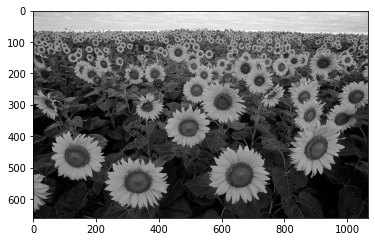

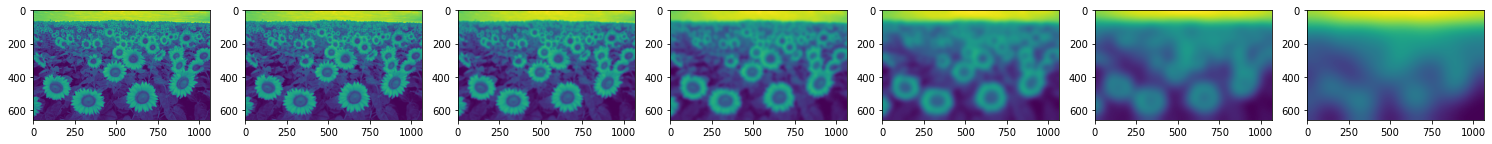

In [2]:
# Load image
img = cv2.imread('sunflowers.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
if SHOW_PLOT: plt.imshow(gray, cmap="gray")

def plot_images(pic):
    fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(26, 6))
    ax[0].imshow(pic[0])
    ax[1].imshow(pic[1])
    ax[2].imshow(pic[2])
    ax[3].imshow(pic[3])
    ax[4].imshow(pic[4])
    ax[5].imshow(pic[5])
    ax[6].imshow(pic[6])

def scaleSpaced(im, sigma, n):
    blurred_imgs = []
    for i in range(n):
        blur, _, _ = gaussianSmoothing(im, sigma*2**i)
        blurred_imgs.append(blur)
    return np.array(blurred_imgs)

blurred_imgs = scaleSpaced(gray, 1, 8)
if SHOW_PLOT:
    plot_images(blurred_imgs)

## Exercise 8.2 DoF
Now, create the function ```DoG = difference0fGaussian(im, sigma, $\mathrm{n}$ )```, where DoG is the scale space DoGs of the original image im. Like the scaleSpaced function, the returned images are all the same size as the original.

Max valued for DoG are decresing:  49 44 41 33 28 27 33


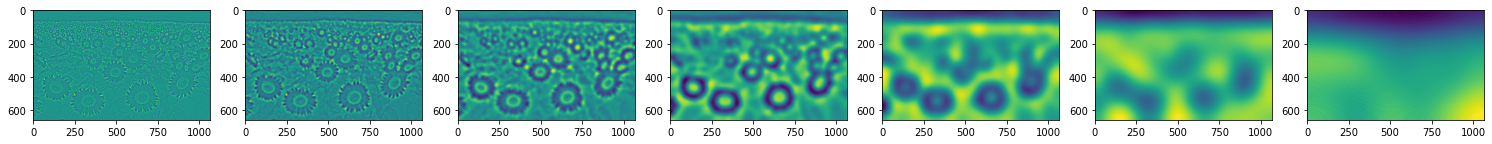

In [3]:
def differenceOfGaussian(im, sigma, n):
    blurred_imgs = scaleSpaced(im, sigma, n)
    DoG = [np.int32(blurred_imgs[i + 1]) - np.int32(blurred_imgs[i])
           for i in range(n - 1)]
    return np.array(DoG)

DoG = differenceOfGaussian(gray,2, 8)
print("Max valued for DoG are decresing: ",np.max(DoG[0]), np.max(DoG[1]), np.max(
    DoG[2]), np.max(DoG[3]), np.max(DoG[4]), np.max(DoG[5]),np.max(DoG[6]))
if SHOW_PLOT:
    plot_images(DoG)

## Exercise 8.3 - Blobs
Finally, create the function blobs $=$ `detectBlobs (im, sigma, n, threshold)`, where blobs are the blobs (pixels) of the original image im with a DoG larger than a threshold. You should also implement non-maximum suppression to increase the robustness of the detector.

Try the detector on the image of sunflowers. Visualize your result by drawing a circle for each image, with the radius proportional to the scale of the blob. You can use cv2. circle for this.

--------

There are 2 algorithms which we can use, NLoG or DoG. In NLoG we also scale the image, in DoG (which we are implementing) we dont scale it! Here we can for example choose as a candidates max values on 3x3x3 kernel, and then we apply the threshold (so for example only best half of the points is stored). As a result we get some points in 3D, wherer the sigma stores the info about the scale. Then we plot the points at the image (dont forget that the 3rd dimension is only how much the image is blurred, otherwise we still operate in 2D).

Detected blobs: 3234
Maximum possible blobs:  54965.625


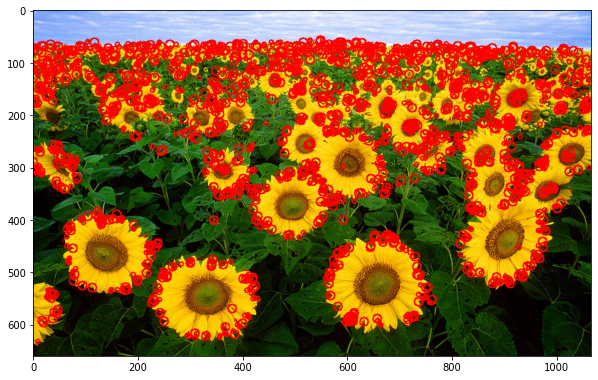

In [4]:
def max_kernel(matrix,thresh):
    # Return the x,y pixel value if its max in 3x3 neigborhood, otherwise 0
    idx = np.argmax(matrix)
    return idx // 9, idx%9//3, idx%3

def detectBlobs(im, sigma, n,threshold):
    # Return list of blobs in format [(x,y,n),...]
    ret = []
    kernel = 4 #6x6x6 must be lower than n-1
    DoG = differenceOfGaussian(im,sigma, n)
    for z in range(len(DoG)//kernel):
        for y in range(len(im)//kernel):
            for x in range(len(im[0])//kernel):
                matrix = np.array(DoG[(kernel*z):(kernel*z+kernel), (kernel*y):(kernel*y+kernel), (kernel*x):(kernel*x+kernel)])
                if np.max(matrix)>threshold:
                    x_ret, y_ret,z_ret = max_kernel(matrix, threshold)
                    ret.append((kernel*x+x_ret, kernel*y+y_ret, kernel*z+z_ret))
    print("Detected blobs:",len(ret))
    print("Maximum possible blobs: ",len(DoG)*len(im)*len(im[0])/(kernel*kernel*kernel))
    return np.array(ret)

blobs = detectBlobs(gray,sigma,n,threshold)
im_copy = img.copy()
b, g, r = cv2.split(im_copy)
im_copy = cv2.merge([r, g, b])
for blob in blobs:
    cv2.circle(img=im_copy, center=tuple((blob[0], blob[1])), radius=blob[2]*4, color=(255, 0, 0), thickness=2)
fig, ax = plt.subplots(1, figsize=(10, 10))
plt.imshow(im_copy)
plt.show()

# Using SIFT FEATURES
The SIFT feature detector and matcher are quite difficult to implement, so we will use existing implementations. However, first we need a good test case scenario.

## Exercise 8.4
Create the function `$r_im = transformIm(im, theta, s)`, where r_im is a scaled and rotated version of the original image im. In this case, theta is a rotation angle and $s$ is a scale factor.
Use this function to produce a transformed version of the test image r_im3.

Detected blobs: 2369
Maximum possible blobs:  48287.96875


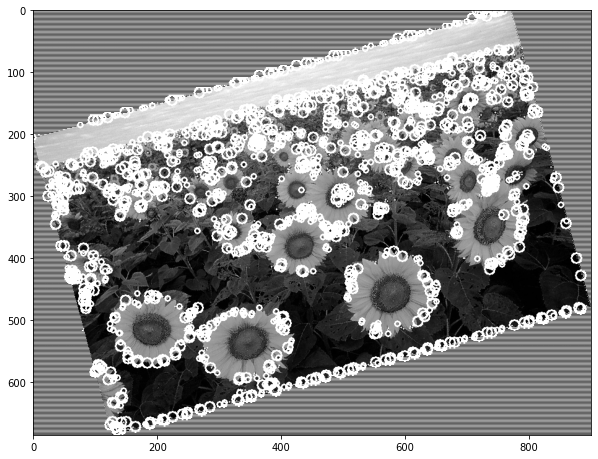

Detected blobs: 2304
Maximum possible blobs:  48287.96875


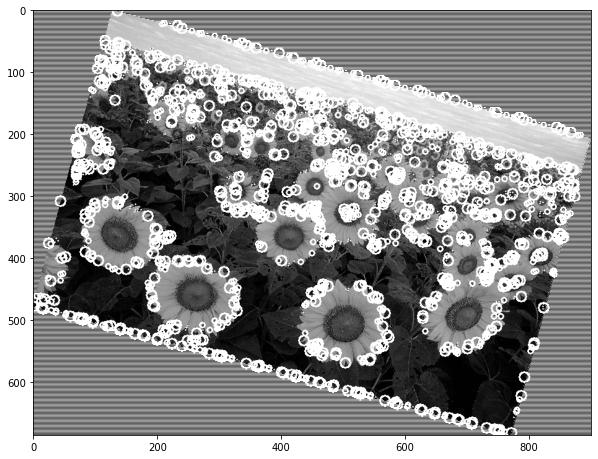

In [5]:
def transformIm(im, theta, s):
    # Setup
    w, h = im.shape
    y, x = np.meshgrid(
        np.linspace(0, w, w, dtype=int), np.linspace(0, h, h, dtype=int))
    x = x.flatten() * s
    y = y.flatten() * s
    locs = np.vstack((x, y))

    # Rotate
    theta = theta*np.pi/180
    R = np.array([[np.cos(theta), np.sin(theta)],
                  [-np.sin(theta), np.cos(theta)]])
    # Rotate
    rotated = R@locs
    # Scale
    rotated[0, :] = rotated[0, :] - rotated[0, :].min()
    rotated[1, :] = rotated[1, :] - rotated[1, :].min()

    # Create canvas
    x_axis = math.ceil(rotated[0, :].max()-rotated[0, :].min())
    y_axis = math.ceil(rotated[1, :].max()-rotated[1, :].min())
    canvas = np.zeros(shape=(y_axis, x_axis))*im.min()
    canvas[::2] = im.max()  # To break up the flat surface
    # Draw onto canvas
    for i in range(len(im[0])):
        for j in range(len(im[:, i])):
            iteration = i * len(im[:, i]) + j
            xpos = np.int32(rotated[0, iteration])
            ypos = np.int32(rotated[1, iteration])
            color = im[j, i]
            canvas[ypos, xpos] = color

    return np.uint8(canvas)

# ROTATION NUMERO UNO
rot_im_1 = transformIm(gray, theta=15, s=0.75)
blobs = detectBlobs(rot_im_1, sigma, n, threshold)
for blob in blobs:
    cv2.circle(img=rot_im_1, center=tuple(
        (blob[0], blob[1])), radius=blob[2]*4, color=(255, 0, 0), thickness=2)
fig, ax = plt.subplots(1, figsize=(10, 10))
plt.imshow(rot_im_1, cmap="gray")
plt.show()

# ROTATION NUMERO DUE
rot_im_2 = transformIm(gray, theta=-15, s=0.75)
blobs = detectBlobs(rot_im_2, sigma, n, threshold)
for blob in blobs:
    cv2.circle(img=rot_im_2, center=tuple(
        (blob[0], blob[1])), radius=blob[2]*4, color=(255, 0, 0), thickness=2)
fig, ax = plt.subplots(1, figsize=(10, 10))
plt.imshow(rot_im_2, cmap="gray")
plt.show()

## Henrik Implementation 

Amount of blobs: 244
Mean value of maximas: 29.204918032786885


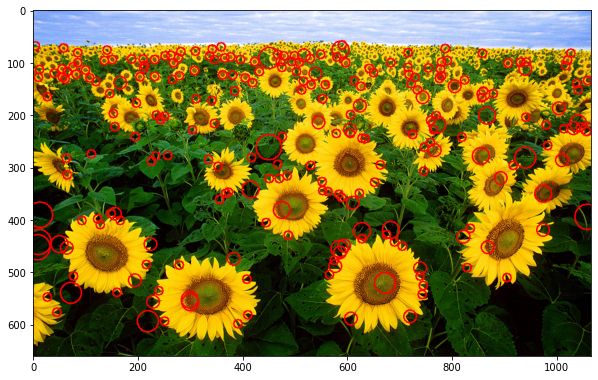

In [6]:
from scipy import ndimage

def non_maximum_suppression(data, order=1):
    """Detects local maxima in a 3D array

    params:
        : data : 3d ndarray
        : order : int
            How many points on each side to use for the comparison
    return:
        : coords : ndarray
            coordinates of the local maxima
        : values : ndarray
            values of the local maxima
    """
    size = 1 + 2 * order
    footprint = np.ones((size, size, size))
    footprint[order, order, order] = 0

    filtered = ndimage.maximum_filter(data, footprint=footprint)
    mask_local_maxima = data > filtered
    data[~mask_local_maxima] = 0
    
    return data

# TODO: smarter threshold - applied after non-max
def detectBlobs(im, sigma, n, threshold, order=1):
    """
    A simple blob detction algorithm using thresholding and non-max-supression of DoGs
    to detect. It's simple as it does not incorporate rotation assignment or discarding 
    of edge blobs.
        params:
            - im: the grayscaled input image where blobs will be sought.
            - sigma: the variance used in the first layer of DoGs
            - n: The number of gaussians produced. More gaussians are required for scale invariance.
            - threshold: Simple thresholding of DoG to discard non-blob objects.
            - order: size of 3D kernel used for non-max-supression of blobs
        return:
            - A tuple (xs, ys, rs, vals) of pixel coordinates of blobs in original image, and what blurr level
            the point was chosen from, and what values those points held
    """
    # 1 Get all DoGs 
    DoG = differenceOfGaussian(im=im,sigma=sigma, n=n)
    # 2 Stack them all
    stack = np.array([DoG[i] for i in range(len(DoG))])
    # 3 Non max supression in 3D
    stack = non_maximum_suppression(stack, order=order)
    # 5 Get non-zero location
    xs, ys, vals = [], [], []
    rs = np.array([1], dtype=np.uint8)
    for i in range(len(DoG)):
        x, y = np.where(stack[i]>threshold)
        xs += list(x)
        ys += list(y)
        vals += list(stack[i][x, y])
        rs = np.hstack((rs, np.ones(shape=(len(x),), dtype=np.uint8)*(i+1)))
    return (np.array(xs), np.array(ys), rs[1:], np.array(vals))

blobs = detectBlobs(im=gray, sigma=1, n=8, threshold=20, order=2)
print("Amount of blobs:", len(blobs[0]))
print("Mean value of maximas:", np.mean(blobs[3]))

im_copy = img.copy()
b,g,r = cv2.split(im_copy)
im_copy = cv2.merge([r,g,b])

for i in range(len(blobs[0])):
    cv2.circle(img=im_copy, center=(blobs[1][i], blobs[0][i]), radius=blobs[2][i]*4, color=(255, 0, 0), thickness=2)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(im_copy)
fig.savefig('ex8_plot2.jpg', bbox_inches='tight',dpi=500)

## Exercise 8.5
Use the SIFT detector to detect features in both the original and the transformed image. Plot the features on top of the images. There are quite a few parameters to play with. Try changing them and see the results.
Now match the features to each other. For this you can use cv2. BFMatcher().
Plot the matches; do they look qualitatively correct?
Filter your matches with the ratio test. Does this remove incorrect matches?

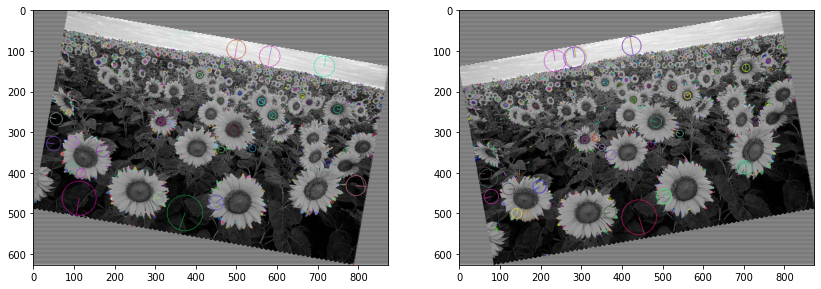

In [7]:
t1 = transformIm(gray, theta=-10, s=0.75)
t2 = transformIm(gray, theta=10, s=0.75)

# Use SIFT to getkeypoints and their descriptors
sift = cv2.SIFT_create(nfeatures = 1000, # no.best features to retain
                                   nOctaveLayers = 5, # Octave layer in DoG - automatically computed
                                   contrastThreshold = 0.04, #Filter out weak features in semi-uniform regions. The larger the threshold, the less features are produced by the detector.
                                   edgeThreshold = 10000, # Filter out edge-like features. The larger this Threshold, the less features are filtered out. 
                                   sigma = 1.6 ) # Sigma of the gaussian at octave 0
kp1, des1 = sift.detectAndCompute(t1, None) #Keypoints and descriptors
kp2, des2 = sift.detectAndCompute(t2, None) #Keypoints and descriptors

# Draw the keypoints on the images
kp1_img = cv2.drawKeypoints(t1, kp1, t1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kp2_img = cv2.drawKeypoints(t2, kp2, t2, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14,6))
axs[0].imshow(kp1_img, cmap="gray")
axs[1].imshow(kp2_img, cmap="gray")

## Matching BFMatcher()

In [8]:
bf = cv2.BFMatcher()
matches_1 = bf.match(des1, des2)
matches_2 = bf.knnMatch(des1,des2,k=2)

### Matching: sorted match
* the bf.match allows you to sort the matches so that only the closest matches are displayed

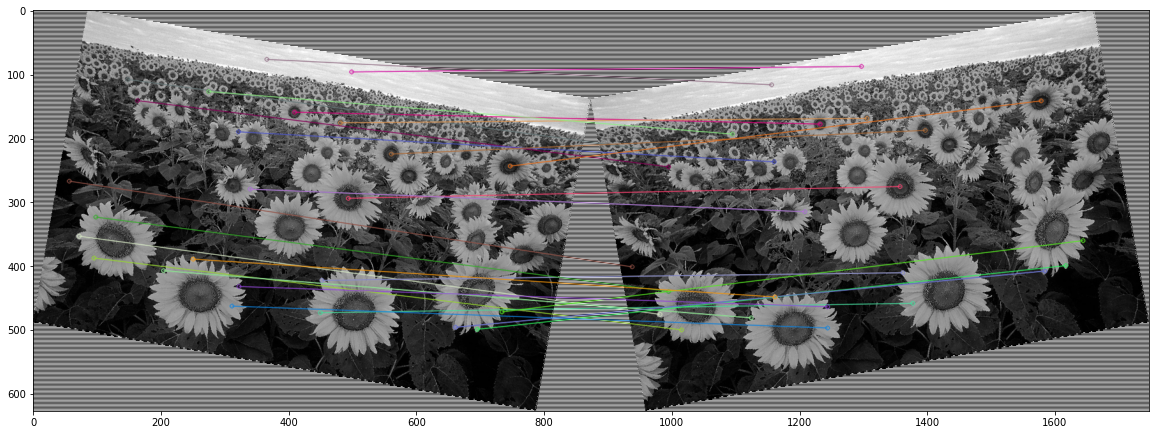

In [9]:
# We can sort the matches, to get the closest matches first
sorted_matches = sorted(matches_1, key = lambda x:x.distance)
# We then draw our matches onto one image
img3 = cv2.drawMatches(t1,kp1,t2,kp2,sorted_matches[:30],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
#
plt.figure(figsize = (20,20))
plt.imshow(img3)

### Filter Matches - KNN
* using the ratio test from the lecture, on the KNN matcher
* KNN matcher contains two and two matchees (best and second best)

Distinctive matches: 399
Before ratio test
After ratino test


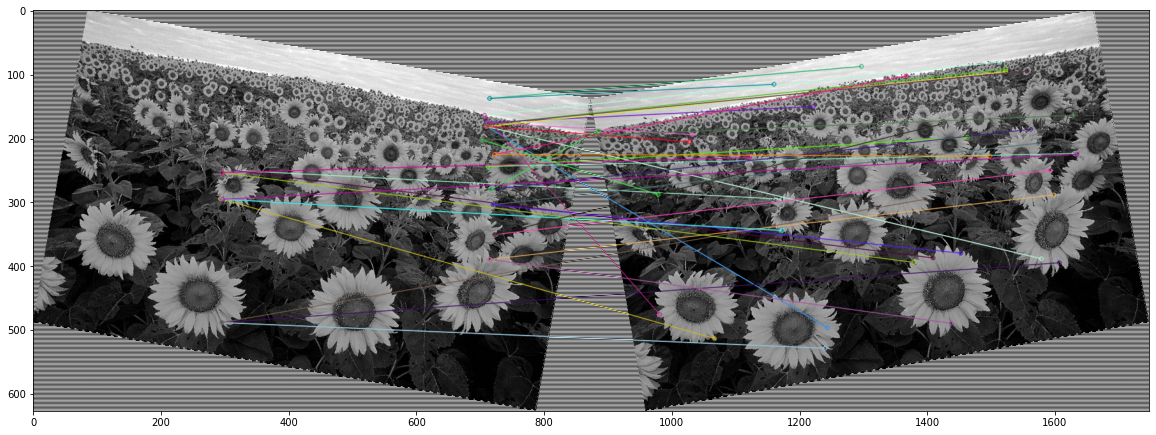

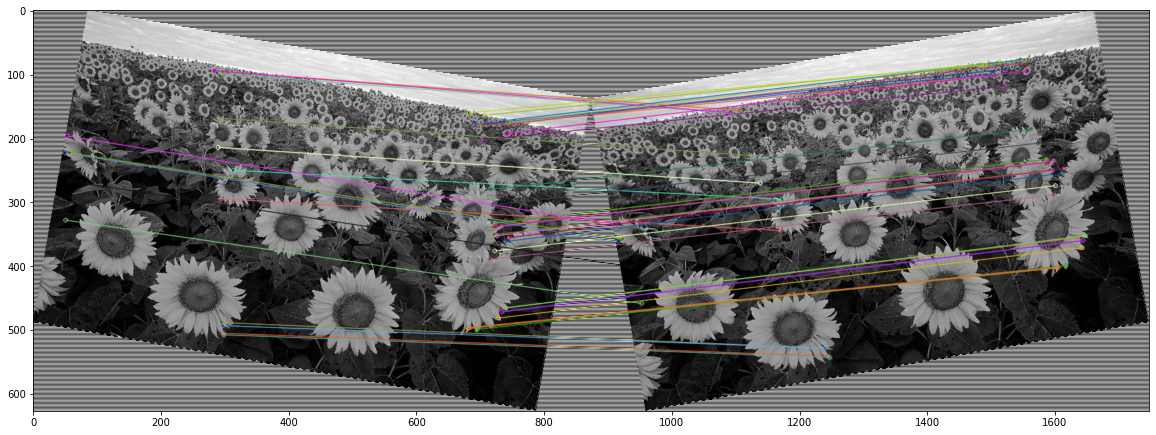

In [10]:
# only keep matches that are distinctive enough
good = []
for m,n in matches_2:
    if m.distance < 0.75*n.distance:
        good.append([m])
print("Distinctive matches:", len(good))

### BEFORE RATION TEST ###
# We then draw our matches onto one image
print("Before ratio test")
img4 = cv2.drawMatchesKnn(t1,kp1,t2,kp2,matches_2[:20],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (20,20))
plt.imshow(img4)

### AFTER RATINO TEST ###
# We then draw our matches onto one image
print("After ratino test")
img5 = cv2.drawMatchesKnn(t1,kp1,t2,kp2,good[:50],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (20,20))
plt.imshow(img5)
plt.savefig('ex8_plot1.jpg', bbox_inches='tight',dpi=500)

### Conclusion
Both sorting matches by distance and using ratio test worked really well in providing good matches, with only few misses. 

## Exercise 8.6
Take two photos of the same scene from different angles using e.g. your smartphone and find matching SIFT features.

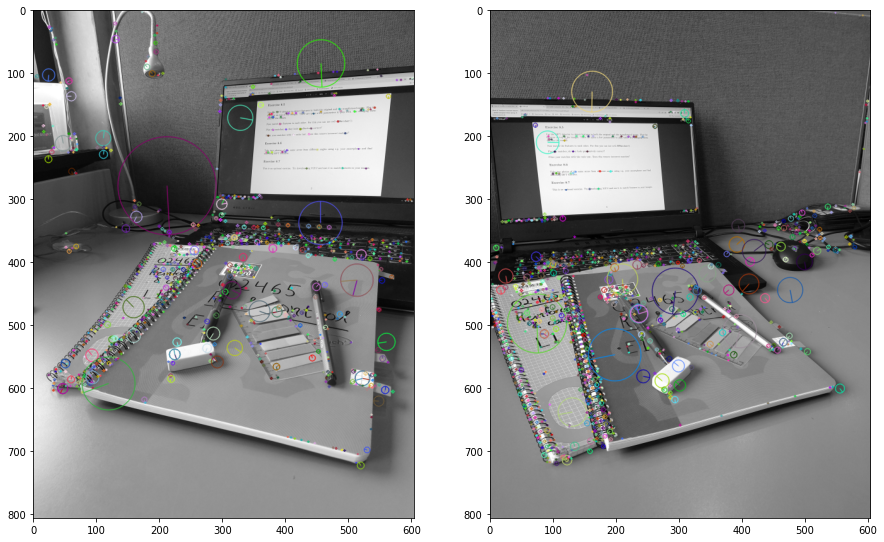

In [11]:
# Load image
left_color = cv2.imread('week08_data/image_from_left.jpg')
left = cv2.cvtColor(left_color, cv2.COLOR_RGB2GRAY)
right_color = cv2.imread('week08_data/image_from_right.jpg')
right = cv2.cvtColor(right_color, cv2.COLOR_RGB2GRAY)

# Need to scale down images for better visualization
scale_percent = 20 # percent of original size
width = int(right.shape[1] * scale_percent / 100)
height = int(right.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
right = cv2.resize(right, dim, interpolation = cv2.INTER_AREA)
left = cv2.resize(left, dim, interpolation = cv2.INTER_AREA)

# Use SIFT to getkeypoints and their descriptors
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(right, None)
kp2, des2 = sift.detectAndCompute(left, None)

# Draw the keypoints on the images
kp1_img = cv2.drawKeypoints(right, kp1, right, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kp2_img = cv2.drawKeypoints(left, kp2, left, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,15))
axs[0].imshow(kp1_img, cmap="gray")
axs[1].imshow(kp2_img, cmap="gray")


### BFF Matcher

Now we can see the method struggeling a bit more
- About 20% of matches seem to be off
- It seems to struggle with objects "leaving the frame": too big angle between each image

Lets try the KNN matches with ratio test

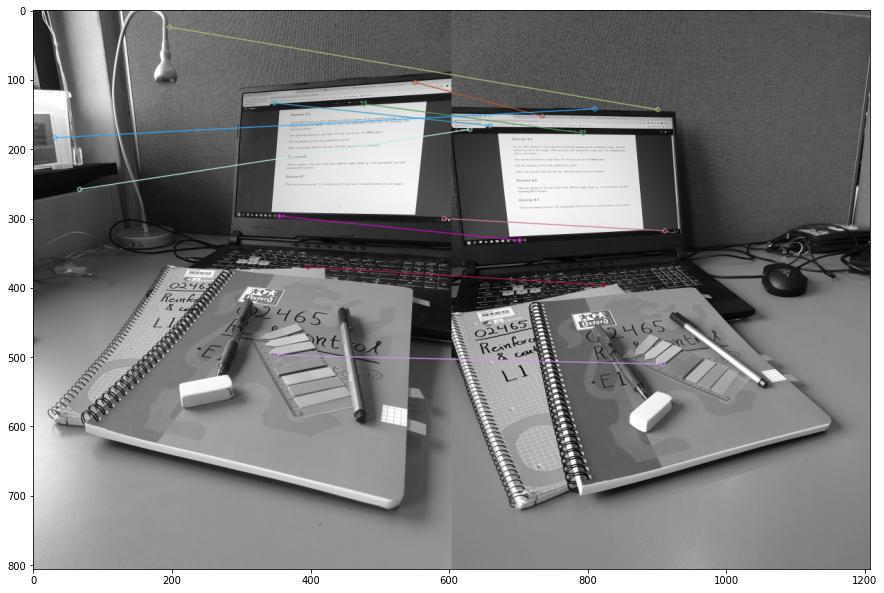

In [12]:
# Match using the brute force matcher or KNN matcher
bf = cv2.BFMatcher()
matches_1 = bf.match(des1, des2)
matches_2 = bf.knnMatch(des1, des2, k=2)

# We can sort the matches, to get the closest matches first
sorted_matches = sorted(matches_1, key = lambda x:x.distance)
# We then draw our matches onto one image
img6 = cv2.drawMatches(right,kp1,left,kp2,sorted_matches[:10],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (15,15))
plt.imshow(img6)

### KNN
- Seems to do a bit better! The struggle still seems to be when objects leave the frame.

Distinctive matches: 47


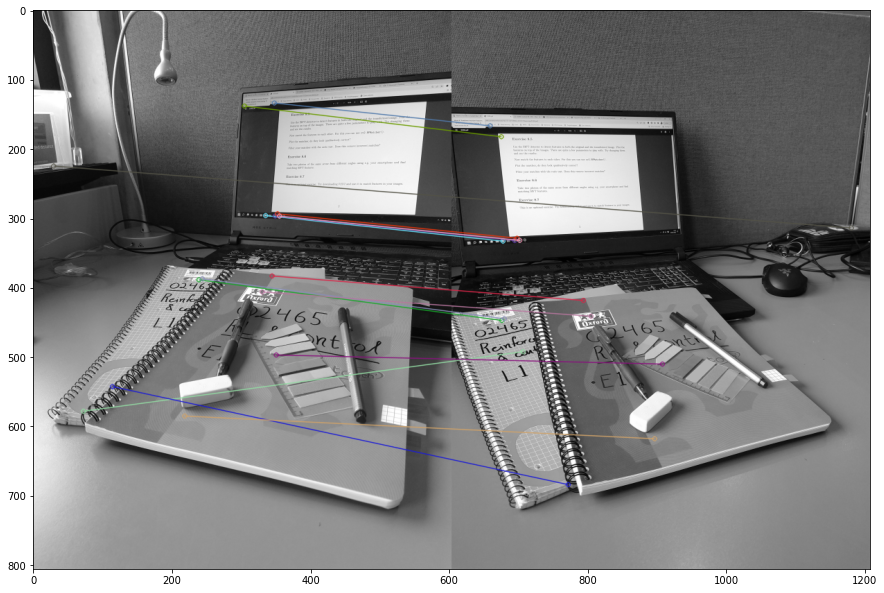

In [13]:
# only keep matches that are distinctive enough
good = []
for m,n in matches_2:
    if m.distance < 0.75*n.distance:
        good.append([m])
print("Distinctive matches:", len(good))

## We then draw our matches onto one image
img7 = cv2.drawMatchesKnn(right, kp1, left, kp2, good[:15],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (15,15))
plt.imshow(img7)

## Exercise 8.7
The R2D2 is a "repeatable and reliable detector and descriptor", presented in 2019. 

```Abstract```\
"Interest point detection and local feature description are fundamental steps in many computer vision applications. Classical approaches are based on a detect-then-describe paradigm where separate handcrafted methods are used to first identify repeatable keypoints and then represent them with a local descriptor. 

Neural networks trained with metric learning losses have recently caught up with these techniques, focusing on learning repeatable saliency maps for keypoint detection or learning descriptors at the detected keypoint locations. 

In this work, we argue that repeatable regions are not necessarily discriminative and can therefore lead to select suboptimal keypoints. Furthermore, we claim that descriptors should be learned only in regions for which matching can be performed with high confidence. We thus propose to jointly learn keypoint detection and description together with a predictor of the local descriptor discriminativeness. This allows to avoid ambiguous areas, thus leading to reliable keypoint detection and description. Our detection-and-description approach simultaneously outputs sparse, repeatable and reliable keypoints that outperforms state-of-the-art detectors and descriptors on the HPatches dataset and on the recent Aachen Day-Night localization benchmark."


https://www.youtube.com/watch?v=ywypX9TWAsE&ab_channel=AIP-State-of-the-ArtAIResearch

In [14]:
%run r2d2-master/extract.py --model models/r2d2_WASF_N16.pt --images week08_data/image_from_right.jpg --top-k 5000

Exception: File `'r2d2-master/extract.py'` not found.

**Oh no...** The GPU is odler than the CUDA software. Could try to install an older version of CUDA.